In [1]:
%env THEANO_FLAGS='device=cuda', 'floatX=float32'

env: THEANO_FLAGS='device=cuda', 'floatX=float32'


In [2]:
from psgd.sampling import SimpleSampler

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

import theano
import theano.tensor as T

from craynn.layers import *
from craynn.networks import *
from craynn.subnetworks import *
from craynn.updates import *
from craynn.utils import lsum
from craynn.viz import SNNWatcher, draw_to_notebook

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Using cuDNN version 7005 on context None
Preallocating 2027/8110 Mb (0.250000) on cuda
Mapped name None to device cuda: GeForce GTX 1080 (0000:01:00.0)


In [4]:
logreg = net((None, 1))(
    dense(1, lambda x: x),
    flatten(1)
)

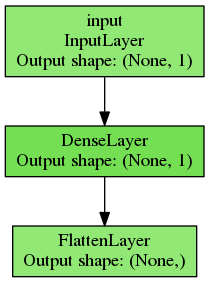

In [5]:
draw_to_notebook(logreg)

In [6]:
X_pos = T.fmatrix()
X_neg = T.fmatrix()
w = T.fvector()

In [7]:
f_pos, = logreg(X_pos)
f_neg, = logreg(X_neg)

In [8]:
losses = (T.nnet.softplus(-f_pos) + T.nnet.softplus(f_neg)) / 2

loss = T.mean(w * losses)

In [9]:
grad = theano.grad(T.sum(losses), logreg.params())
grad_norm = T.sqrt(
    lsum([ T.sum(g ** 2) for g in grad ])
)

In [10]:
get_grad_norm = theano.function([X_pos, X_neg], grad_norm)

In [11]:
learning_rate = T.fscalar()

upd, rst = resetable.adam(grad, logreg.params(), learning_rate=learning_rate)

train = theano.function(
    [X_pos, X_neg, w, learning_rate],
    [loss, grad_norm],
    updates=upd, allow_input_downcast=True
)

reset = theano.function([], None, updates=rst)

### Functions for the case without fixed batch structure

In [12]:
x1 = T.fvector()
x2 = T.fvector()

y1 = T.fscalar()
y2 = T.fscalar()

w1 = T.fscalar()
w2 = T.fscalar()

f1, = logreg(x1.reshape((-1, 1)))
f2, = logreg(x2.reshape((-1, 1)))

In [13]:
loss1 = T.sum(y1 * T.nnet.softplus(-f1) + (1 - y1) * T.nnet.softplus(f1))
loss2 = T.sum(y2 * T.nnet.softplus(-f2) + (1 - y2) * T.nnet.softplus(f2))

loss = (w1 * loss1 + w2 * loss2) / 2

In [14]:
grad1 = theano.grad(T.sum(loss1), logreg.params())
grad1_norm = T.sqrt(
    lsum([ T.sum(g ** 2) for g in grad1 ])
)

grad2 = theano.grad(T.sum(loss2), logreg.params())
grad2_norm = T.sqrt(
    lsum([ T.sum(g ** 2) for g in grad2 ])
)

In [15]:
get_grad_norm1 = theano.function([x1, y1], grad1_norm)

In [16]:
learning_rate = T.fscalar()

upd, rst = resetable.adam(loss, logreg.params(), learning_rate=learning_rate)

train2 = theano.function(
    [x1, y1, w1, x2, y2, w2, learning_rate],
    [loss, grad1_norm, grad2_norm],
    updates=upd, allow_input_downcast=True
)

reset2 = theano.function([], None, updates=rst)

## Data

In [17]:
data_pos = np.random.normal(size=(500, )).astype('float32') + 1.25
data_neg = np.random.normal(size=(500, )).astype('float32') + 0.75

data_pos = np.sort(data_pos).reshape(-1, 1)
data_neg = np.sort(data_neg).reshape(-1, 1)

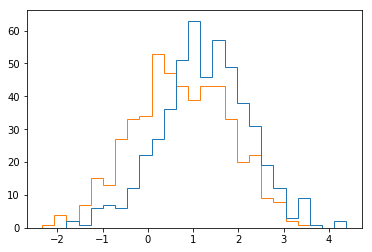

In [18]:
_ = plt.hist([data_pos[:, 0], data_neg[:, 0]], histtype='step', bins=25)

In [19]:
from sklearn.neighbors import KDTree

kdtree = KDTree(data_neg, leaf_size=16)

In [20]:
### link positive data points to negative ones

indx = np.ones(shape=(data_pos.shape[0]), dtype='int64') * (-1)

used_points = set()

for i in np.random.permutation(data_pos.shape[0]):
    match_found = False
    k = 10
    
    while not match_found:
        js = kdtree.query(data_pos[i, :].reshape(1, -1), k=k, return_distance=False)[0]
        for j in js:
            if not j in used_points:
                used_points.add(j)
                indx[i] = j
                match_found = True
                break
        k += 10

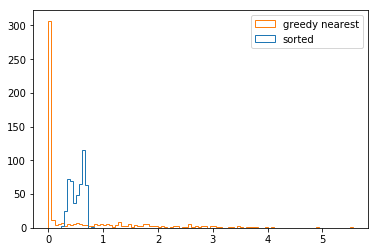

In [21]:
r1 = np.abs(data_pos[:, 0] - data_neg[:, 0])
r2 = np.abs(data_pos[:, 0] - data_neg[indx, 0])
_ = plt.hist([r1, r2], histtype='step', bins=100, label=['sorted', 'greedy nearest'])
plt.legend()

In [22]:
data_neg = data_neg[indx, :]

## Obtaining solution

In [23]:
initial_params = logreg.weights

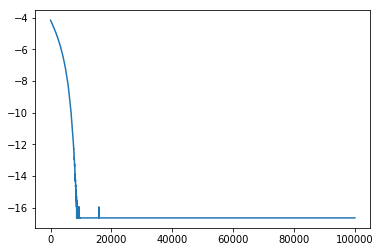

In [24]:
num_epoches = int(1.0e+5)

logreg.weights = initial_params

losses = np.ndarray(shape=(num_epoches, ), dtype='float32')
w = np.ones(shape=(data_pos.shape[0], ), dtype='float32')
for i in range(num_epoches):
    losses[i], _ = train(data_pos, data_neg, w, 1.0e-4)

_ = plt.plot(np.log(losses - np.min(losses)))

In [25]:
solution = logreg.weights

In [26]:
num_epoches = 500
num_batches = 50

## Uniform sampling

In [27]:
losses = np.ndarray(shape=(num_epoches, num_batches), dtype='float32')
r = np.ndarray(shape=(num_epoches, ), dtype='float64')

In [28]:
logreg.weights = initial_params
reset()

for epoch in range(num_epoches):
    for i in range(num_batches):
        i1, i2 = np.random.choice(data_neg.shape[0], size=2)

        losses[epoch, i], grad = train(
            np.array([data_pos[i1]], dtype='float32'),
            np.array([data_neg[i2]], dtype='float32'),
            np.array([1.0]),
            1.0e-4
        )
    
    r[epoch] = np.sqrt(
        np.sum([ (p-p0) ** 2 for p, p0 in zip(logreg.weights, solution) ])
    )

In [29]:
loss_means = np.mean(losses, axis=1)
loss_stds = np.std(losses, axis=1)

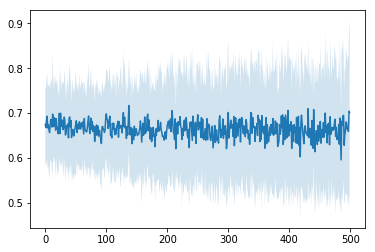

In [30]:
plt.plot(loss_means)
plt.fill_between(np.arange(loss_means.shape[0]), loss_means - loss_stds, loss_means + loss_stds, alpha=0.2)

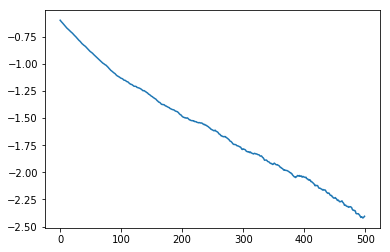

In [31]:
plt.plot(np.log(r))

## (Almost) ideal sampling

In [32]:
sampler = SimpleSampler(n_objects=data_pos.shape[0])

In [33]:
losses2 = np.ndarray(shape=(num_epoches, num_batches), dtype='float32')
r2 = np.ndarray(shape=(num_epoches, ), dtype='float64')

In [34]:
logreg.weights = initial_params
reset()

prior = 1.0 / data_pos.shape[0]

for epoch in range(num_epoches):
    grads = np.array([
        get_grad_norm(data_pos[k].reshape(-1, 1), data_neg[k].reshape(-1, 1)) + 1.0e-2
        for k in range(data_pos.shape[0])
    ], dtype='float32')

    sampler.set_probas(grads)
    sampler.update()

    indx, probs = sampler.sample(num_batches)

    for i in range(num_batches):
        k = indx[i]
        w = prior / probs[i]
        losses2[epoch, i], _ = train(
            np.array([data_pos[k]], dtype='float32'),
            np.array([data_neg[k]], dtype='float32'),
            np.array([w], dtype='float32'),
            1.0e-4
        )
        
    r2[epoch] = np.sqrt(
        np.sum([ (p-p0) ** 2 for p, p0 in zip(logreg.weights, solution) ])
    )

In [35]:
loss_means = np.mean(losses2, axis=1)
loss_stds = np.std(losses2, axis=1)

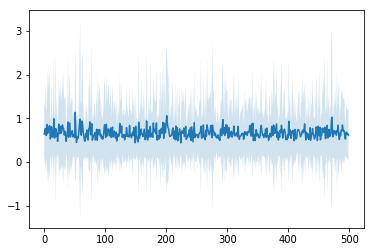

In [36]:
plt.plot(loss_means)
plt.fill_between(np.arange(loss_means.shape[0]), loss_means - loss_stds, loss_means + loss_stds, alpha=0.2)

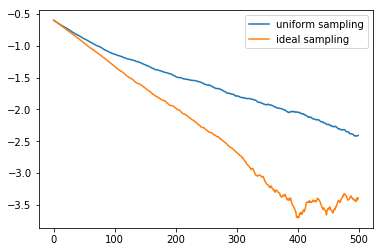

In [37]:
plt.plot(np.log(r), label='uniform sampling')
plt.plot(np.log(r2), label='ideal sampling')
plt.legend()

## Adaptive sampling

In [38]:
losses3 = np.ndarray(shape=(num_epoches, num_batches), dtype='float32')
r3 = np.ndarray(shape=(num_epoches, ), dtype='float64')

In [39]:
logreg.weights = initial_params
reset()

prior = 1.0 / data_pos.shape[0]

grad_estimation = np.mean([
    get_grad_norm(data_neg[k].reshape(-1, 1), data_pos[k].reshape(-1, 1))
    for k in np.random.choice(data_neg.shape[0], size=100)
])

grads = np.ones(shape=(data_pos.shape[0], ), dtype='float32') * grad_estimation
rho = 0.8

for epoch in range(num_epoches):
    sampler.set_probas(grads)

    indx, probs = sampler.sample(num_batches)

    for i in range(num_batches):
        k = indx[i]
        w = prior / probs[i]

        losses3[epoch, i], g = train(
            data_pos[k].reshape(-1, 1),
            data_neg[k].reshape(-1, 1),
            np.array([w], dtype='float32'),
            1.0e-4
        )
        
        grads[k] = grads[k] * rho + (1 - rho) * g
        
    r3[epoch] = np.sqrt(
        np.sum([ (p-p0) ** 2 for p, p0 in zip(logreg.weights, solution) ])
    )

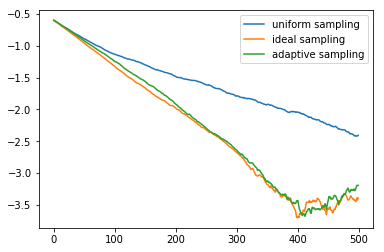

In [40]:
plt.plot(np.log(r), label='uniform sampling')
plt.plot(np.log(r2), label='ideal sampling')
plt.plot(np.log(r3), label='adaptive sampling')
plt.legend()

### Classical (almost) ideal IS

In [41]:
losses4 = np.ndarray(shape=(num_epoches, num_batches), dtype='float32')
r4 = np.ndarray(shape=(num_epoches, ), dtype='float64')

In [42]:
sampler2 = SimpleSampler(n_objects=data_pos.shape[0] + data_neg.shape[0])

In [43]:
logreg.weights = initial_params
reset()

prior = 1.0 / data_pos.shape[0]

for epoch in range(num_epoches):
    grads = np.array([
        get_grad_norm1(data_neg[k], 0.0) for k in range(data_neg.shape[0])
    ] + [
        get_grad_norm1(data_pos[k], 1.0) for k in range(data_pos.shape[0])
    ], dtype='float32')

    sampler2.set_probas(grads)

    indx, probs = sampler2.sample(num_batches * 2)

    for i in range(num_batches):
        k1 = indx[2 * i]
        w1 = prior / probs[2 * i]
        x1 = data_neg[k1] if k1 < data_neg.shape[0] else data_pos[k1 - data_neg.shape[0]]
        y1 = 0.0 if k1 < data_neg.shape[0] else 1.0
        
        k2 = indx[2 * i + 1]
        w2 = prior / probs[2 * i + 1]
        x2 = data_neg[k2] if k2 < data_neg.shape[0] else data_pos[k2 - data_neg.shape[0]]
        y2 = 0.0 if k2 < data_neg.shape[0] else 1.0
        
        losses4[epoch, i], _, _ = train2(x1, y1, w1, x2, y2, w2, 1.0e-4)
        
    r4[epoch] = np.sqrt(
        np.sum([ (p-p0) ** 2 for p, p0 in zip(logreg.weights, solution) ])
    )

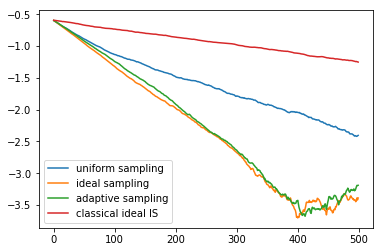

In [44]:
plt.plot(np.log(r), label='uniform sampling')
plt.plot(np.log(r2), label='ideal sampling')
plt.plot(np.log(r3), label='adaptive sampling')
plt.plot(np.log(r4), label='classical ideal IS')
plt.legend()

### Classical Adaptive IS

In [45]:
losses5 = np.ndarray(shape=(num_epoches, num_batches), dtype='float32')
r5 = np.ndarray(shape=(num_epoches, ), dtype='float64')

In [46]:
logreg.weights = initial_params
reset()

prior = 1.0 / data_pos.shape[0]

grad_estimation = np.mean([
    get_grad_norm1(data_neg[k], 0.0) for k in np.random.choice(data_neg.shape[0], size=50)
] + [
    get_grad_norm1(data_pos[k], 1.0) for k in np.random.choice(data_pos.shape[0], size=50)
])

grads = np.ones(shape=(data_pos.shape[0] + data_neg.shape[0], ), dtype='float32') * grad_estimation
rho = 0.8

for epoch in range(num_epoches):
    sampler2.set_probas(grads)

    indx, probs = sampler2.sample(num_batches * 2)

    for i in range(num_batches):
        k1 = indx[2 * i]
        w1 = prior / probs[2 * i]
        x1 = data_neg[k1] if k1 < data_neg.shape[0] else data_pos[k1 - data_neg.shape[0]]
        y1 = 0.0 if k1 < data_neg.shape[0] else 1.0
        
        k2 = indx[2 * i + 1]
        w2 = prior / probs[2 * i + 1]
        x2 = data_neg[k2] if k2 < data_neg.shape[0] else data_pos[k2 - data_neg.shape[0]]
        y2 = 0.0 if k2 < data_neg.shape[0] else 1.0
        
        losses4[epoch, i], g1, g2 = train2(x1, y1, w1, x2, y2, w2, 1.0e-4)
        
        grads[k1] = rho * grads[k1] + (1 - rho) * g1
        grads[k2] = rho * grads[k2] + (1 - rho) * g2
        
    r5[epoch] = np.sqrt(
        np.sum([ (p-p0) ** 2 for p, p0 in zip(logreg.weights, solution) ])
    )

### Results

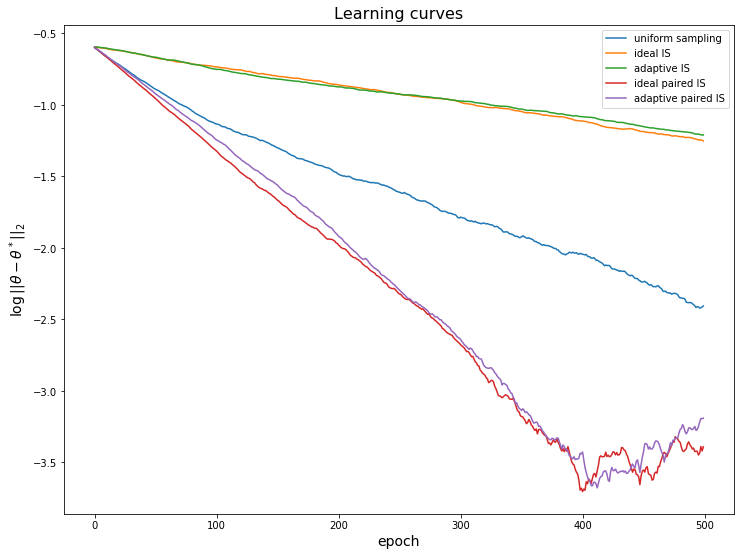

In [54]:
plt.figure(figsize=(12, 9))

plt.plot(np.log(r), label='uniform sampling')

plt.plot(np.log(r4), label='ideal IS')
plt.plot(np.log(r5), label='adaptive IS')

plt.plot(np.log(r2), label='ideal paired IS')
plt.plot(np.log(r3), label='adaptive paired IS')

plt.title('Learning curves', fontsize=16)

plt.xlabel('epoch', fontsize=14)
plt.ylabel(r'$\log\,||\theta - \theta^*||_2$', fontsize=14)

plt.legend()